In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join, exists, split
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')

import glmsingle
from glmsingle.glmsingle import GLM_single

# note: the fracridge repository is also necessary to run this code
# for example, you could do:
#      git clone https://github.com/nrdg/fracridge.git

datadir = '/zpool/vladlab/data_drive/fmri_tutorial/glmsingle_data'
outputdir = '/zpool/vladlab/data_drive/fmri_tutorial/glmsingle_output'
# get path to the directory to which GLMsingle was installed
os.makedirs(datadir,exist_ok=True)
os.makedirs(outputdir,exist_ok=True)

print(f'directory to save example dataset:\n\t{datadir}\n')
print(f'directory to save example2 outputs:\n\t{outputdir}\n')

directory to save example dataset:
	/zpool/vladlab/data_drive/fmri_tutorial/glmsingle_data

directory to save example2 outputs:
	/zpool/vladlab/data_drive/fmri_tutorial/glmsingle_output



In [2]:
# download example dataset from GLMsingle OSF repository
# data comes from subject1, floc session from NSD dataset.
# https://www.biorxiv.org/content/10.1101/2021.02.22.432340v1.full.pdf

datafn = join(datadir,'nsdflocexampledataset.mat')

# to save time, we'll skip the download if the example dataset already exists on disk
if not exists(datafn):
    
    print(f'Downloading example dataset and saving to:\n{datafn}')
    
    dataurl = 'https://osf.io/g42tm/download'
    
    # download the .mat file to the specified directory
    urllib.request.urlretrieve(dataurl, datafn)
    
# load struct containing example dataset
X = sio.loadmat(datafn)

In [3]:
# variables that will contain bold time-series and design matrices from each run
data = []
design = []

nruns = len(X['data'][0])

# iterate through each run of data
#This creates a design file with each row corresponding to a TR of data
for r in range(nruns):
    
    # index into struct, append each run's timeseries data to list
    data.append(X['data'][0,r])
    
    # convert each run design matrix from sparse array to full numpy array, append
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
# get shape of data volume (XYZ) for convenience
xyz = data[0].shape[:3]
xyzt = data[0].shape

# get total number of blocks - this will be the dimensionality of output betas from GLMsingle
nblocks = int(np.sum(np.concatenate(design)))

# get metadata about stimulus duration and TR
stimdur = X['stimdur'][0][0]
tr = X['tr'][0][0]

In [4]:
design[0].shape

(234, 10)

In [5]:
data[0].shape

(52, 81, 42, 234)

In [6]:
#convert design[0] to a pandas DataFrame
# this will be useful for plotting later
design_df = pd.DataFrame(design[0], columns=['cond1', 'cond2', 'cond3', 'cond4', 'cond5', 'cond6', 'cond7', 'cond8', 'cond9', 'cond10'])

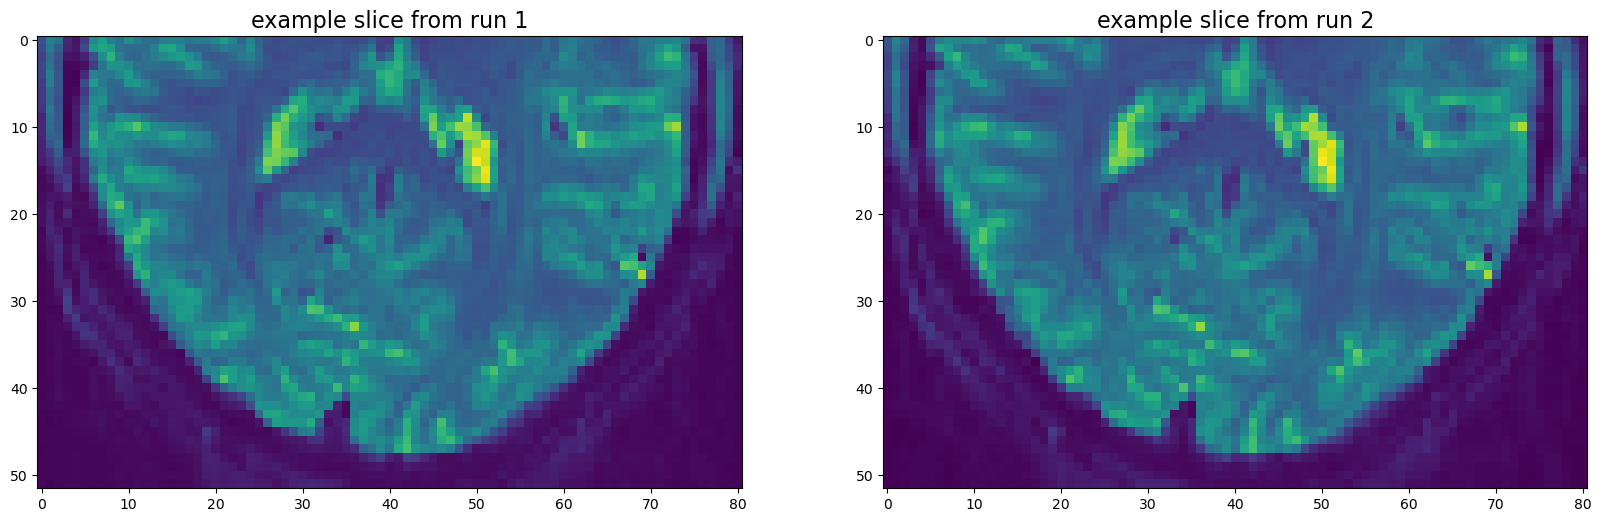

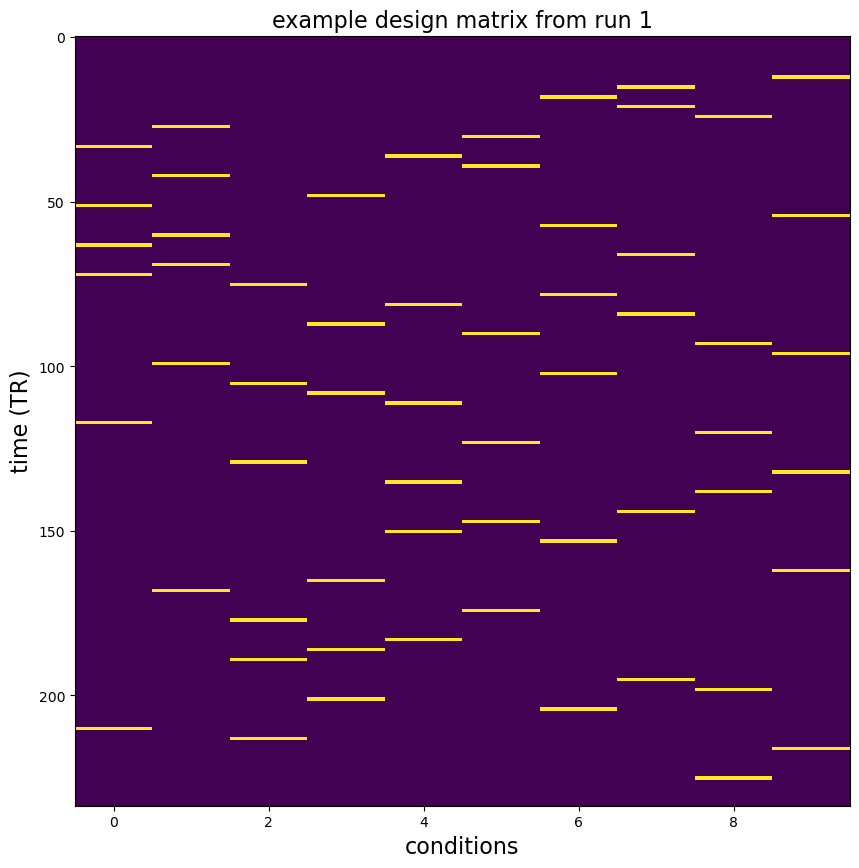

In [7]:
V1_roi = X['visual'].item()[0] == 1   # for V1
FFA_roi = X['floc'].item()[0] == 2    # for FFA-1
# plot example slices from runs 1 and 2
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(data[0][:,:,20,0])
plt.title('example slice from run 1',fontsize=16)
plt.subplot(122)
plt.imshow(data[1][:,:,20,0])
plt.title('example slice from run 2',fontsize=16)

# plot example design matrix from run 1
plt.figure(figsize=(10,10))
plt.imshow(design[0],aspect='auto',interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16);

In [8]:
# print some relevant metadata
print(f'Data has {len(data)} runs\n')
print(f'There are {nblocks} total blocks in runs 1-4\n')
print(f'Shape of data from each run is: {data[0].shape}\n')
print(f'XYZ dimensionality is: {data[0].shape[:3]} (one slice only)\n')
print(f'N = {data[0].shape[3]} TRs per run\n')
print(f'Numeric precision of data is: {type(data[0][0,0,0,0])}\n')
print(f'There are {np.sum(FFA_roi)} voxels in the included FFA ROI\n')
print(f'There are {np.sum(V1_roi)} voxels in the included V1 ROI')

Data has 4 runs

There are 240 total blocks in runs 1-4

Shape of data from each run is: (52, 81, 42, 234)

XYZ dimensionality is: (52, 81, 42) (one slice only)

N = 234 TRs per run

Numeric precision of data is: <class 'numpy.float32'>

There are 484 voxels in the included FFA ROI

There are 594 voxels in the included V1 ROI


In [9]:
# create a directory for saving GLMsingle outputs
outputdir_glmsingle = join(outputdir,'examples','example2outputs','GLMsingle')
opt = dict()

# set important fields for completeness (but these would be enabled by default)
# wantlibrary = 1 -> fit HRF to each voxel 
# wantglmdenoise = 1 -> use GLMdenoise 
# wantfracridge = 1 -> use ridge regression to improve beta estimates 
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
#opt['wantmemoryoutputs'] = [1,1,1,1]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'firdelay': 30,
 'firpct': 99,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1750634884.9100242,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wanthdf5': 0,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [ ]:
'''
Run this in script
'''
start_time = time.time()
results_glmsingle = glmsingle_obj.fit(
    design,
    data,
    stimdur,
    tr,
    outputdir=outputdir_glmsingle)

elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')

*** DIAGNOSTICS ***:
There are 4 runs.
The number of conditions in this experiment is 10.
The stimulus duration corresponding to each trial is 4.00 seconds.
The TR (time between successive data points) is 1.33 seconds.
The number of trials in each run is: [60, 60, 60, 60].
The number of trials for each condition is: [np.int64(24), np.int64(24), np.int64(24), np.int64(24), np.int64(24), np.int64(24), np.int64(24), np.int64(24), np.int64(24), np.int64(24)].
For each condition, the number of runs in which it appears: [np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4)].
For each run, how much ending buffer do we have in seconds? [np.float64(10.666666666666666), np.float64(10.666666666666666), np.float64(10.666666666666666), np.float64(10.666666666666666)].
*** Saving design-related results to /zpool/vladlab/data_drive/fmri_tutorial/glmsingle_output/examples/example2outputs/GLMsingle/DESIGNINFO.npy. ***
*** FITTI

: 

In [ ]:
# load existing file outputs if they exist
# we assign outputs of GLMsingle to the "results_glmsingle" variable.
# note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
# where all images are treated as the same condition. these estimates
# could be potentially used to find cortical areas that respond to
# visual stimuli. we want to compare beta weights between conditions
# therefore we are not going to include the ONOFF betas in any analyses of 
# voxel reliability

#typ a: ONOFF model regardless of condition
#typ b: FITHRF model with condition-specific HRF
#typ c: FITHRF model with condition-specific HRF and GLMdenoise
#typ d: FITHRF model with condition-specific HRF, GLMdenoise, and ridge regression


results_glmsingle = dict()
results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

In [26]:
#these are the betas from for each conditoin at each voxel
betas = results_glmsingle['typed']['betasmd']



In [27]:
betas.shape

(52, 81, 42, 240)

In [28]:
mean_betas = np.mean(betas,axis=3)

In [29]:
mean_betas.shape

(52, 81, 42)

In [ ]:
#using design_df, extract each 1 value in order and list its scondition 
conditions = []
condition_index = []
#loop through each row of the design_df
for i in range(len(design_df)):
    #check if the row is all zeros
    if np.all(design_df.iloc[i].values == 0):
        # if so, skip this row
        continue
    #get the columns where the value is 1
    cols = np.where(design_df.iloc[i].values == 1)[0]
    #get the condition name from the first column
    condition = design_df.columns[cols[0]]
    #append the condition to the list
    conditions.append(condition)
    #append the index of the condition to the list
    condition_index.append(i)

In [34]:
#faces = cond5 and cond6
#scenes = cond9 and cond10

#get the indices of the faces and scenes conditions
faces_indices = [i for i, cond in enumerate(conditions) if cond in ['cond5', 'cond6']]
scenes_indices = [i for i, cond in enumerate(conditions) if cond in ['cond9', 'cond10']]


# get the mean betas for faces and scenes
mean_betas_faces = np.mean(betas[:,:,:,faces_indices], axis=3)
mean_betas_scenes = np.mean(betas[:,:,:,scenes_indices], axis=3)

(np.float64(-0.5), np.float64(80.5), np.float64(51.5), np.float64(-0.5))

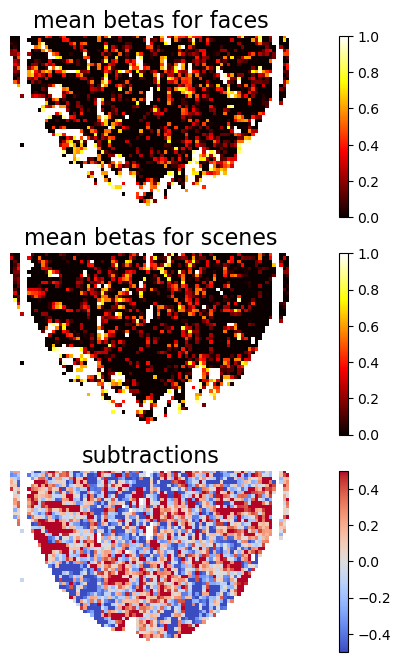

In [42]:
meanvol = np.squeeze(np.mean(data[0].reshape(xyzt),3))
brainmask = meanvol > 275

#mask out the brain
mean_betas_faces[~brainmask] = np.nan
mean_betas_scenes[~brainmask] = np.nan
subtract_betas = mean_betas_faces - mean_betas_scenes

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)

plt.imshow(mean_betas_faces[:,:,20], cmap='hot', vmin=0, vmax=1)
plt.title('mean betas for faces', fontsize=16)
plt.colorbar()
plt.axis('off')
plt.subplot(3,1,2)
plt.imshow(mean_betas_scenes[:,:,20], cmap='hot', vmin=0, vmax=1)
plt.colorbar()
plt.title('mean betas for scenes', fontsize=16)
plt.axis('off')
plt.subplot(3,1,3)
#plot difference
plt.imshow(subtract_betas[:,:,20], cmap='coolwarm', vmin=-0.5, vmax=0.5)
plt.colorbar()

plt.title('subtractions', fontsize=16)
plt.axis('off')


In [38]:
#create a subplot with three rows
# in subplot 1, plot the mean betas for faces, in subplot 2, plot the mean betas for scenes, in subplot 3, plot the difference between faces and scenes
fix, ax = plt.subplot(3,  figsize=(10, 15))
# plot mean betas for faces
ax[0].imshow(mean_betas_faces[:,:,20], cmap='hot', interpolation='none')
ax[0].set_title('Mean Betas for Faces', fontsize=16)
# plot mean betas for scenes
ax[1].imshow(mean_betas_scenes[:,:,20], cmap='hot', interpolation='none')
ax[1].set_title('Mean Betas for Scenes', fontsize=16)
# plot difference between faces and scenes
ax[2].imshow(mean_betas_faces[:,:,20] - mean_betas_scenes[:,:,20], cmap='hot', interpolation='none')
ax[2].set_title('Difference between Faces and Scenes', fontsize=16)
plt.tight_layout()
plt.show()

ValueError: Single argument to subplot must be a three-digit integer, not 3

<Figure size 640x480 with 0 Axes>

In [22]:
np.squeeze(results_glmsingle['typed']['betasmd']).shape

(52, 81, 42, 240)

In [24]:
np.sum(design[0])*4

np.float64(240.0)

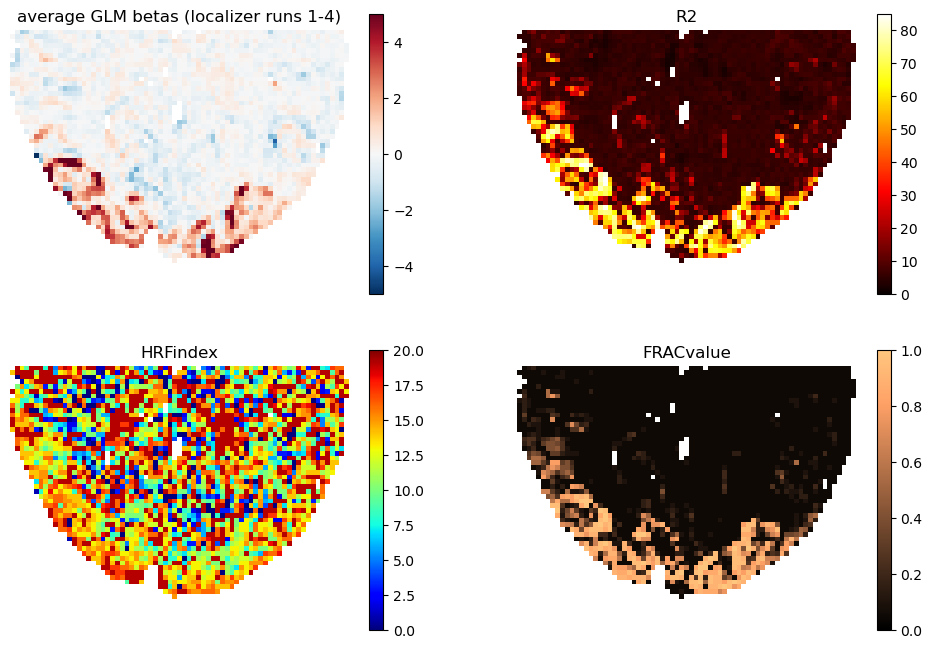

In [20]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

meanvol = np.squeeze(np.mean(data[0].reshape(xyzt),3))
brainmask = meanvol > 275

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        plot_data = np.nanmean(np.squeeze(results_glmsingle['typed'][plot_fields[i]]),3).astype(float)
        titlestr = 'average GLM betas (localizer runs 1-4)'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data = np.squeeze(results_glmsingle['typed'][plot_fields[i]].reshape(xyz)).astype(float)
        titlestr = plot_fields[i]
    
    plot_data[~brainmask] = np.nan # remove values outside the brain for visualization purposes
    plt.imshow(plot_data[:,5:-5,20],cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)